In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2.5
    minIzero = 0.01
    lin_filter = 0.2
    image_threshold = 2
    hot_pixel = 6

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 50/2, nshots=None)
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Energy_pump, Energy_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    (_, _, _, _, _, _, Laser_pump, Laser_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_PIPS_fluo, channel)
    
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.mean(Energy_pump)
    
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.mean(Energy_unpump)
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
#     print('numon')
#     print(IzeroFEL_pump.shape[0])
    
#     print('numoff')
#     print(IzeroFEL_unpump.shape[0])
    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    images_thr_on[np.isnan(images_thr_on)] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0
    images_thr_off[np.isnan(images_thr_off)] = 0
    
#     print('num nan')
#     print(sum(sum(sum(np.isnan(images_thr_on)))))
    
#     print('Izero')
#     print(np.mean(IzeroFEL_unpump))
#     print(np.mean(IzeroFEL_pump))
#     print(np.max(IzeroFEL_unpump))
#     print(np.min(IzeroFEL_unpump))
    
    IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump = \
        filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
    

    
#     print(images_thr_on.shape)
#     print(images_thr_on.shape)
    
    images_thr_on = images_thr_on[condFinalPump]
    images_thr_off = images_thr_off[condFinalUnPump]

#     print('number of surviving frames')
#     print(images_thr_on.shape[0])
#     print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    XES_on[np.isnan(XES_on)] = 0
    XES_off[np.isnan(XES_off)] = 0
    
#     print('num nan')
#     print(sum(sum(np.isnan(XES_on))))
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
#     print(XES_on.shape)
#     print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp
        
    FloFEL_pump_total = np.mean(DataFluo_pump)/np.mean(IzeroFEL_pump)
    FloFEL_unpump_total = np.mean(DataFluo_unpump)/np.mean(IzeroFEL_unpump)
    
    return XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

    condition = np.logical_and(Y<260, Y>253)
    Z[condition] = 0
    
    Z[Y>320] = 0
    Z[Y < 200] = 0

    condition = np.logical_not(np.logical_and(X<200, X>130))
    Z[condition] = 0

    #plt.figure()
    #plt.imshow(Z)
    
    #plt.colorbar()
    
    return Z

Run for RIXS

In [5]:
ynCompare12 = 'yes'
normalize = False

folder_name_01 = 'XES_2836.5eV_600fs'
# folder_name_01 = 'XES_2842.0eV_10ps'
run_list_01 = [435,438]

folder_name_02 = 'XES_2836.5eV_10ps'
# folder_name_02 = 'XES_2842.0eV_10ps'
run_list_02 = [460]




folder_name = folder_name_01
run_list = run_list_01

filename_base = "run_"

DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"



iterCounter = 0

for ii in run_list:


    XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
        get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 2, channel_energy, True)

    
        
    if False:

        plt.figure()
        plt.subplot(1,2,1)
        plt.title('ON')
        plt.imshow(XES_on, vmax = 0.001)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.title('OFF')
        plt.imshow(XES_off, vmax = 0.001)
        plt.colorbar()
        plt.tight_layout()

    
    if iterCounter == 0:
        rixs_on = XES_on.sum(axis=0)
        rixs_off = XES_off.sum(axis=0)
    else:
        rixs_on = np.vstack((rixs_on,XES_on.sum(axis=0)))
        rixs_off = np.vstack((rixs_off,XES_off.sum(axis=0)))

    
    
    iterCounter +=1

    
xAxis = np.linspace(1,XES_on.shape[1],XES_on.shape[1])
 
if len(run_list) == 1:
    RIXS_on_01 = rixs_on
    RIXS_off_01 = rixs_off
else:
    RIXS_on_01 = rixs_on.sum(axis=0)
    RIXS_off_01 = rixs_off.sum(axis=0)
    
err_on_01 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
err_off_01 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)

/das/work/p17/p17983/cropped_data/XES_2836.5eV_600fs/run_000435.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2836.5eV_600fs/run_000435.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500
/das/work/p17/p17983/cropped_data/XES_2836.5eV_600fs/run_000438.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2836.5eV_600fs/run_000438.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500


In [6]:
if ynCompare12 == 'yes':

    folder_name = folder_name_02
    run_list = run_list_02
    DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"

    iterCounter = 0

    for ii in run_list:

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.title('ON')
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.title('OFF')
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()


        if iterCounter == 0:
            rixs_on = XES_on.sum(axis=0)
            rixs_off = XES_off.sum(axis=0)
        else:
            rixs_on = np.vstack((rixs_on,XES_on.sum(axis=0)))
            rixs_off = np.vstack((rixs_off,XES_off.sum(axis=0)))

        iterCounter +=1

    if len(run_list) == 1:
        RIXS_on_02 = rixs_on
        RIXS_off_02 = rixs_off
    else:
        RIXS_on_02 = rixs_on.sum(axis=0)
        RIXS_off_02 = rixs_off.sum(axis=0)
        
    err_on_02 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
    err_off_02 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)
    

/das/work/p17/p17983/cropped_data/XES_2836.5eV_10ps/run_000460.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2836.5eV_10ps/run_000460.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
2500
2500


<IPython.core.display.Javascript object>


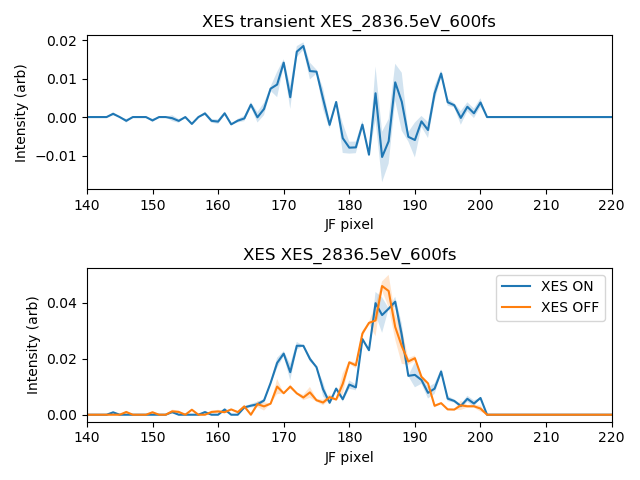

In [7]:
RIXS_trans_01 = (RIXS_on_01-RIXS_off_01)
err_trans_01 = err_adder(err_on_01,err_off_01)
if normalize:
    RIXS_trans_01 = RIXS_trans_01/RIXS_off_01
    err_trans_01 = RIXS_trans_01/RIXS_off_01*err_adder(err_trans_01/RIXS_trans_01,err_off_01/RIXS_off_01)

    
xRange_01 = [140,220]

plt.figure()
plt.subplot(2,1,1)
plt.plot(xAxis,RIXS_trans_01)
plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
plt.xlabel('JF pixel')
plt.ylabel('Intensity (arb)')
plt.title('XES transient '+folder_name_01)
plt.xlim(xRange_01)

plt.subplot(2,1,2)
plt.plot(xAxis,RIXS_on_01, label ='XES ON')
plt.fill_between(xAxis,RIXS_on_01+err_on_01,RIXS_on_01-err_on_01, alpha = 0.2)
plt.plot(xAxis,RIXS_off_01, label = 'XES OFF')
plt.fill_between(xAxis,RIXS_off_01+err_off_01,RIXS_off_01-err_off_01, alpha = 0.2)
plt.xlabel('JF pixel')
plt.ylabel('Intensity (arb)')
plt.title('XES ' +folder_name_01)
plt.xlim(xRange_01)
plt.legend()

plt.tight_layout()


<IPython.core.display.Javascript object>


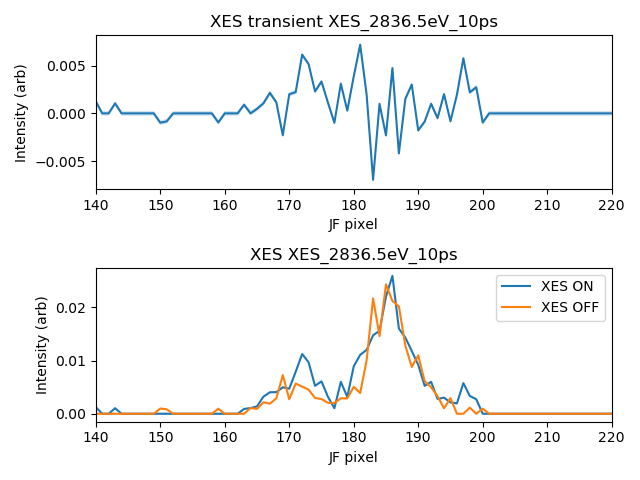

In [8]:
if ynCompare12 == 'yes':
    RIXS_trans_02 = (RIXS_on_02-RIXS_off_02)
    err_trans_02 = err_adder(err_on_02,err_off_02)
    if normalize:
        RIXS_trans_02 = RIXS_trans_02/RIXS_off_02
        err_trans_02 = RIXS_trans_02/RIXS_off_02*err_adder(err_trans_02/RIXS_trans_02,err_off_02/RIXS_off_02)


    xRange_02 = xRange_01

    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(xAxis,RIXS_trans_02)
    plt.fill_between(xAxis,RIXS_trans_02+err_trans_02,RIXS_trans_02-err_trans_02,alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES transient '+folder_name_02)
    plt.xlim(xRange_02)

    plt.subplot(2,1,2)
    plt.plot(xAxis,RIXS_on_02, label ='XES ON')
    plt.fill_between(xAxis,RIXS_on_02+err_on_02,RIXS_on_02-err_on_02, alpha = 0.2)
    plt.plot(xAxis,RIXS_off_02, label = 'XES OFF')
    plt.fill_between(xAxis,RIXS_off_02+err_off_02,RIXS_off_02-err_off_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES ' +folder_name_02)
    plt.xlim(xRange_02)
    plt.legend()

    plt.tight_layout()

<IPython.core.display.Javascript object>


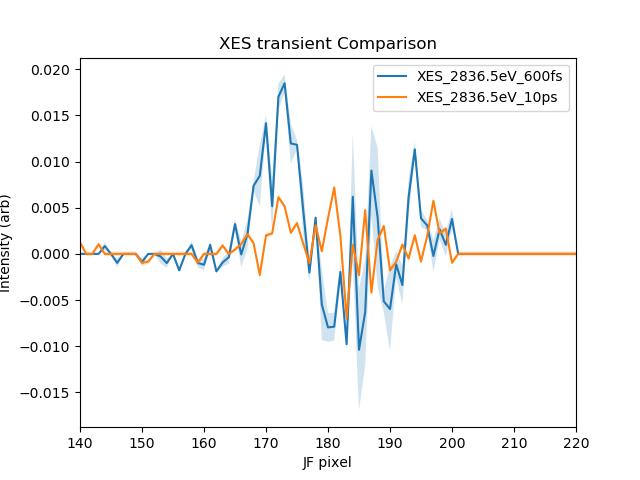

<IPython.core.display.Javascript object>


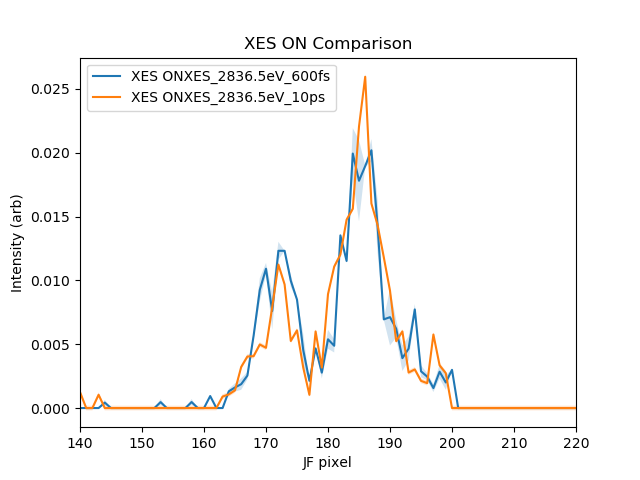

<IPython.core.display.Javascript object>


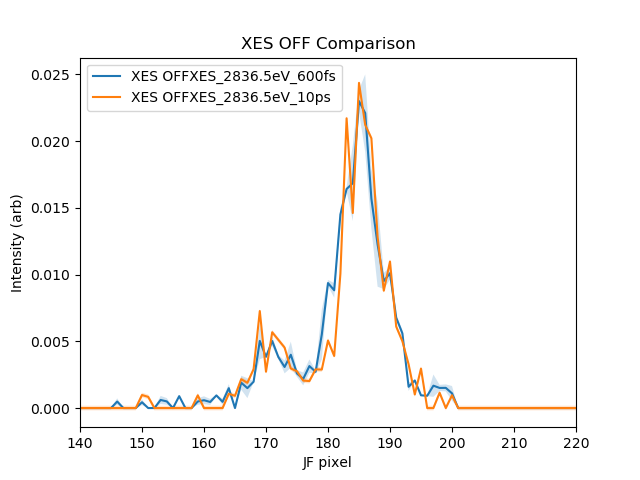

In [9]:
if ynCompare12 == 'yes':
    scale_01 = len(run_list_01)
    scale_02 = len(run_list_02)
    
    plt.figure()
    plt.plot(xAxis,RIXS_trans_01, label = folder_name_01)
    plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
    plt.plot(xAxis,RIXS_trans_02, label = folder_name_02)
    plt.fill_between(xAxis,RIXS_trans_02+err_trans_02,RIXS_trans_02-err_trans_02,alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES transient Comparison')
    plt.legend()
    plt.xlim(xRange_02)
    
    
    plt.figure()
    plt.plot(xAxis,RIXS_on_01/scale_01, label ='XES ON'+folder_name_01)
    plt.fill_between(xAxis,(RIXS_on_01+err_on_01)/scale_01,(RIXS_on_01-err_on_01)/scale_01, alpha = 0.2)
    plt.plot(xAxis,RIXS_on_02/scale_02, label ='XES ON'+folder_name_02)
    plt.fill_between(xAxis,(RIXS_on_02+err_on_02)/scale_02,(RIXS_on_02-err_on_02)/scale_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES ON Comparison')
    plt.legend()
    plt.xlim(xRange_02)
    
    plt.figure()
    plt.plot(xAxis,RIXS_off_01/scale_01, label ='XES OFF'+folder_name_01)
    plt.fill_between(xAxis,(RIXS_off_01+err_off_01)/scale_01,(RIXS_off_01-err_off_01)/scale_01, alpha = 0.2)
    plt.plot(xAxis,RIXS_off_02/scale_02, label ='XES OFF'+folder_name_02)
    plt.fill_between(xAxis,(RIXS_off_02+err_off_02)/scale_02,(RIXS_off_02-err_off_02)/scale_02, alpha = 0.2)
    plt.xlabel('JF pixel')
    plt.ylabel('Intensity (arb)')
    plt.title('XES OFF Comparison')
    plt.legend()
    plt.xlim(xRange_02)